In [5]:
from src.generate_data import Data
from src.evaluate import *
from src.models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [8]:
%%time
data = Data(layer_size=16)

C:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 703 ms
Wall time: 757 ms


In [9]:
%%time
train, val, test = data.get_splits(['random_subsample'], [[0.25, 0.75]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 992 train | 595 val | 2382 test
CPU times: total: 359 ms
Wall time: 355 ms


#### Peek at unshuffled train data

In [10]:
train_original[:20]

[[',,..,__._,.,._.,', '______.,_.uw._.,', '___..,__.__dr_._', True],
 [',___,,._,,.__.,.', '__._,__w__._,,,,', '_,.,,,.,_.dr_...', True],
 [',...__..,.,,,_..', '.,___.__.wu___.,', '._cr._..__,,,.,.', False],
 ['.,,._.._.,_,,,..', '_..__,,,.,.__.,,', ',_,._._,_,.r,,__', True],
 ['.__.,,.,,_.,___,', '_._,,,._..._,_,,', '._.,_dr.,,.._,__', True],
 [',,__,,_.___...,_', '_,__,_,_,,_._..,', '_,.,,cr.._,.._,.', False],
 ['.._...,.,._,,.,,', ',._,,.,,,.w_._.,', ',,.,,__.,.__,__,', False],
 ['._.,..._.._...._', '_,_...__.,,.wu,_', '_.._.,.._._,_,._', False],
 ['.._._,,_._,....,', '_....__,.,uw,_._', ',.,_,,.._,__r,,,', True],
 ['.,_..,,._,__.,,.', ',___,_.._,_,w.,_', ',,._,,..__,cr__.', False],
 [',..._.____.__,_,', '.,,,_wu_...,_,_,', '_..__,.__,.r....', True],
 [',,.,_,__.,.__.,_', '...,__.,.__._..,', '_,_....,,.cr,__,', False],
 ['._._..,,_,...._.', '_._._,wu_.,___..', '__,.._,_.,.,....', False],
 [',__,,_._.,.,.,,.', 'w._.,,_.._,_..._', '_...__.__..._._.', False],
 ['.,._.,._.,,__,..', '__.

In [11]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 56 | F2-uw 59 | F2-w 64 | F2-noop 65 | 
F3 cr:    F2-wu 56 | F2-uw 52 | F2-w 63 | F2-noop 51 | 
F3 r:    F2-wu 69 | F2-uw 49 | F2-w 67 | F2-noop 71 | 
F3 noop:    F2-wu 69 | F2-uw 54 | F2-w 75 | F2-noop 72 | 

Positive samples count: 444
Total samples count: 992
Positive class ratio: 0.4475806451612903


#### Peek at test data

In [12]:
test_original[:15]

[['.,_,__,,._..,.,.', ',_uw__.,,___,...', ',,_,,_.__,._____', False],
 ['_..,.____.,,.,,_', ',.,......,.,_.,.', ',,,..._,_dr,_,,,', True],
 ['.,_,,__.,..___._', '__.,_,..,_,.._,,', ',.,..._,..,,,,,.', False],
 ['__,._.,..,,__...', '_._.w..,..__,...', '_____,..,.,...dr', True],
 ['.___,,,_,_.._,..', ',____,.,._w____.', '_.cr,....,,.__,.', False],
 ['.,,..,__._..,_._', '__wu.,._,.,__.._', '_cr...,__.,,,,..', False],
 [',.__,.,_..._,.,,', ',_,.,,_,_.,_,wu_', ',,._,._,_r,,,,._', True],
 [',.,.._..,,,.,.__', '_,._uw____,_,__.', '_._...,_,_,r._._', True],
 [',_,,,,,.__...___', ',_._.,,uw_,_,,,_', '.r,_..__,..,,._.', True],
 ['.,_.,__..___._..', ',._._,uw___..,__', '__...,.__.r_._..', True],
 ['_,,,,,_._,,,,..,', ',_,_,_..,..wu__,', '_,..__cr..,,._.,', False],
 ['._,_,_,._,__,_..', '__...,_._..__,wu', '..,_,__...,__,_.', False],
 ['_._,,,.....,.,._', ',_.,uw.,__,,...,', ',..,.,_..__..,.r', True],
 [',.,,..,,__,._._.', '.,wu._,_____..._', '.,r.___,..._,,..', True],
 ['__.,_._,,.,_.._.', ',_.__

In [13]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 140 | F2-uw 133 | F2-w 138 | F2-noop 160 | 
F3 cr:    F2-wu 139 | F2-uw 142 | F2-w 145 | F2-noop 151 | 
F3 r:    F2-wu 132 | F2-uw 149 | F2-w 151 | F2-noop 154 | 
F3 noop:    F2-wu 148 | F2-uw 173 | F2-w 162 | F2-noop 165 | 

Positive samples count: 1017
Total samples count: 2382
Positive class ratio: 0.4269521410579345


#### Peek at val data

In [14]:
val_original[:15]

[[',,,__..__.____,.', 'w___,_._,,.__,,.', '...__,.cr.,,__,.', False],
 [',_..._,_._._,,,.', '_.._._.uw..,,_,_', '_.,,_._.,,.,_cr_', False],
 ['.___.,_.__,.,_.,', '_,,.._.,._..w_.,', '..,_..__.,__.r,.', True],
 ['._,.,,.._,_,.,_,', '.,,uw_.._.....,.', ',.,,,,.r.,,_..._', True],
 ['_..,_.,_,_._,,,,', '__.,,_.uw,,,,..,', '.__.,cr,.,.__..,', False],
 ['_,,._._....,,,_,', ',,_._w._._.__,_,', '_._.r,_..,,.,__,', True],
 ['..__.,_,____,._,', '.,_.w,,,_._,_,__', ',.,.,.,..__._cr,', False],
 ['.,._.,_..,_,,,_,', ',_.._._.____wu__', '.,_,r_.,,_,_.__.', True],
 ['._,._,_,,,___,.,', '..___,___uw.,__.', ',.,....,,_dr,_,_', True],
 ['..,.__.__,,_,___', '____,__._.,uw__.', ',__.,_cr___._,_.', False],
 ['___...,____,,__.', '_,,..._,___,__,.', '.,_,,._._,.,..cr', False],
 [',,._,.,.,_...,_,', 'wu__,._.,____,,,', ',.__,.._.,__,,,r', True],
 ['__.,._,,.______,', '.w..._.._.,_..__', ',.,_dr,._,_,.,._', True],
 [',..,,,__...,,,,,', ',,__._,,,._,,.,_', '_.___..__....,__', False],
 ['_,.._,_,_,.,,,,,', '..,_

In [15]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 29 | F2-uw 33 | F2-w 38 | F2-noop 30 | 
F3 cr:    F2-wu 30 | F2-uw 31 | F2-w 32 | F2-noop 53 | 
F3 r:    F2-wu 39 | F2-uw 42 | F2-w 38 | F2-noop 47 | 
F3 noop:    F2-wu 38 | F2-uw 28 | F2-w 35 | F2-noop 52 | 

Positive samples count: 267
Total samples count: 595
Positive class ratio: 0.44873949579831934


#### Send label arrays to device

In [16]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [17]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [18]:
x_train_normal[0].shape

torch.Size([992, 128])

#### Get data in convolutional format, send to device

In [19]:
x_train_cnn = data.to_conv_format(x_train)
x_val_cnn = data.to_conv_format(x_val)
x_test_cnn = data.to_conv_format(x_test)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [20]:
x_train_cnn[0].shape

torch.Size([992, 128])

#### Get data in LSTM format, send to device

In [21]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [22]:
x_train_lstm[0].shape

torch.Size([992, 16, 8])

### Define training parameters

In [23]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "25per"

### Define training procedure for each model

In [24]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []
    best_accuracy = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./{model_name}_model_TEMP_' + experiment_name))
    
        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original))
        precisions.append(get_precision_by_cases(model, x_test, y_test, test_original))
        recalls.append(get_recall_by_cases(model, x_test, y_test, test_original))
        f1_scores.append(get_f1_by_cases(precisions[-1], recalls[-1]))
        
        wrong_preds.append((f"Experimento {i}", get_wrong_predictions(model, x_test, y_test, test_original)))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model test accuracy:", accuracies[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test precision:", precisions[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test recall:", recalls[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test f1:", f1_scores[-1]['Overall'])


    
    return accuracies, precisions, recalls, f1_scores, wrong_preds, [train_losses, val_losses, train_accs, val_accs], model
    #return accuracies, precisions, wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [25]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1, cnn_wrong_preds, cnn_epoch_stats, model = train_models(
    CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.0001, data, 64, 128, 4, -1, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21016\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.9395465994962217
1 / 20 models trained | Current model test precision: 0.9008264462809917
1 / 20 models trained | Current model test recall: 0.9646017699115044
1 / 20 models trained | Current model test f1: 0.9316239316239316
2 / 20 models trained | Current model test accuracy: 0.9403862300587741
2 / 20 models trained | Current model test precision: 0.8847845206684257
2 / 20 models trained | Current model test recall: 0.9891838741396264
2 / 20 models trained | Current model test f1: 0.9340761374187558
3 / 20 models trained | Current model test accuracy: 0.9416456759026028
3 / 20 models trained | Current model test precision: 0.8810763888888888
3 / 20 models trained | Current model test recall: 0.9980334316617503
3 / 20 models trained | Current model test f1: 0.9359151682803135
4 / 20 models trained | Current model test accuracy: 0.9408060453400504
4 / 20 models trained | Current model test precision: 0.8808695652173913
4 / 20 model

In [26]:
%%time
lstm_accuracies, lstm_precision, lstm_recall, lstm_f1, lstm_wrong_preds, lstm_epoch_stats, model = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21016\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.998320738874895
1 / 20 models trained | Current model test precision: 0.9970559371933267
1 / 20 models trained | Current model test recall: 0.9990167158308751
1 / 20 models trained | Current model test f1: 0.9980353634577603
2 / 20 models trained | Current model test accuracy: 0.9412258606213266
2 / 20 models trained | Current model test precision: 0.8789974070872947
2 / 20 models trained | Current model test recall: 1.0
2 / 20 models trained | Current model test f1: 0.9356025758969642
3 / 20 models trained | Current model test accuracy: 1.0
3 / 20 models trained | Current model test precision: 1.0
3 / 20 models trained | Current model test recall: 1.0
3 / 20 models trained | Current model test f1: 1.0
4 / 20 models trained | Current model test accuracy: 0.9403862300587741
4 / 20 models trained | Current model test precision: 0.8787878787878788
4 / 20 models trained | Current model test recall: 0.9980334316617503
4 / 20 models trai

In [27]:
%%time
deepset_accuracies, deepset_procision, deepset_recall, deepset_f1, deepset_wrong_preds, deepset_epoch_stats, model = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.005, data, 128, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21016\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.9126784214945424
1 / 20 models trained | Current model test precision: 0.8538932633420823
1 / 20 models trained | Current model test recall: 0.95968534906588
1 / 20 models trained | Current model test f1: 0.9037037037037037
2 / 20 models trained | Current model test accuracy: 0.9311502938706969
2 / 20 models trained | Current model test precision: 0.8731408573928259
2 / 20 models trained | Current model test recall: 0.9813176007866273
2 / 20 models trained | Current model test f1: 0.924074074074074
3 / 20 models trained | Current model test accuracy: 0.8988245172124265
3 / 20 models trained | Current model test precision: 0.8887775551102205
3 / 20 models trained | Current model test recall: 0.872173058013766
3 / 20 models trained | Current model test f1: 0.8803970223325063
4 / 20 models trained | Current model test accuracy: 0.9282115869017632
4 / 20 models trained | Current model test precision: 0.8763345195729537
4 / 20 models tr

In [28]:
%%time
deepsetv2_accuracies, deepsetv2_procision, deepsetv2_recall, deepsetv2_f1, deepsetv2_wrong_preds, deepsetv2_epoch_stats, model = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21016\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.4269521410579345
1 / 20 models trained | Current model test precision: 0.4269521410579345
1 / 20 models trained | Current model test recall: 1.0
1 / 20 models trained | Current model test f1: 0.5984112974404237
2 / 20 models trained | Current model test accuracy: 0.4269521410579345
2 / 20 models trained | Current model test precision: 0.4269521410579345
2 / 20 models trained | Current model test recall: 1.0
2 / 20 models trained | Current model test f1: 0.5984112974404237
3 / 20 models trained | Current model test accuracy: 0.4269521410579345
3 / 20 models trained | Current model test precision: 0.4269521410579345
3 / 20 models trained | Current model test recall: 1.0
3 / 20 models trained | Current model test f1: 0.5984112974404237
4 / 20 models trained | Current model test accuracy: 0.4269521410579345
4 / 20 models trained | Current model test precision: 0.4269521410579345
4 / 20 models trained | Current model test recall: 1.0
4 

In [29]:
%%time
feedforward_accuracies, feedforward_precision, feedforward_recall, feedforward_f1, feedforward_wrong_preds, feedforward_epoch_stats, model = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21016\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.9252728799328296
1 / 20 models trained | Current model test precision: 0.8607050730868444
1 / 20 models trained | Current model test recall: 0.984267453294002
1 / 20 models trained | Current model test f1: 0.9183486238532111
2 / 20 models trained | Current model test accuracy: 0.8828715365239295
2 / 20 models trained | Current model test precision: 0.8959227467811158
2 / 20 models trained | Current model test recall: 0.8210422812192724
2 / 20 models trained | Current model test f1: 0.8568496664956388
3 / 20 models trained | Current model test accuracy: 0.9332493702770781
3 / 20 models trained | Current model test precision: 0.8803191489361702
3 / 20 models trained | Current model test recall: 0.976401179941003
3 / 20 models trained | Current model test f1: 0.925874125874126
4 / 20 models trained | Current model test accuracy: 0.8937867338371117
4 / 20 models trained | Current model test precision: 0.8694390715667312
4 / 20 models t

# Evaluation

In [30]:
import pandas as pd
# Lista de modelos y nombres
model_names = ['CNN', 'LSTM', 'DeepSet', 'DeepSetV2', 'Feedforward']
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precision, deepset_procision, deepsetv2_procision, feedforward_precision]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1, lstm_f1, deepset_f1, deepsetv2_f1, feedforward_f1]

imprimirMetricas(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

        Modelo  Accuracy  Precision    Recall  F1-score
0          CNN  0.941646   0.881076  0.998033  0.935915
1         LSTM  1.000000   1.000000  1.000000  1.000000
2      DeepSet  0.934089   0.879859  0.979351  0.926943
3    DeepSetV2  0.426952   0.426952  1.000000  0.598411
4  Feedforward  0.935348   0.883556  0.977384  0.928105


### Get best 50% performing models

In [31]:
top_half = int(num_experiments / 2)
best_cnn_accs = filter_top_k_accuracies(cnn_accuracies, top_half)
best_lstm_accs = filter_top_k_accuracies(lstm_accuracies, top_half)
best_deepset_accs = filter_top_k_accuracies(deepset_accuracies, top_half)
best_deepsetv2_accs = filter_top_k_accuracies(deepsetv2_accuracies, top_half)
best_feedforward_accs = filter_top_k_accuracies(feedforward_accuracies, top_half)

## Accuracy breakdown by cases for all the models

In [32]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [33]:
get_stats_df(all_accuracies, model_names, test_original)

,Overall,cr_noop,cr_uw,cr_w,cr_wu,dr_noop,dr_uw,dr_w,dr_wu,noop_noop,noop_uw,noop_w,noop_wu,r_noop,r_uw,r_w,r_wu
CNN,94.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,13.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,83.8%
LSTM,97.6%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,62.5%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,96.0%
DeepSet(like in paper),90.0%,99.1%,99.4%,99.3%,99.6%,89.9%,87.2%,91.6%,14.3%,99.2%,99.5%,99.1%,99.4%,92.1%,89.2%,90.8%,83.1%
DeepSet(sum at start),42.7%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,100.0%
Feedforward,91.8%,99.1%,99.5%,99.3%,99.6%,96.4%,94.2%,97.0%,8.6%,98.0%,98.3%,98.3%,98.7%,97.0%,94.8%,96.0%,87.2%
Sample count,2382,151,142,145,139,160,133,138,140,165,173,162,148,154,149,151,132


## Accuracy breakdown by cases for top 50% of models

In [34]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['dr', 'r', 'cr', 'noop']

In [35]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN,94.1%,100.0%,77.7%,100.0%,97.8%
LSTM,100.0%,100.0%,100.0%,100.0%,99.9%
DeepSet(like in paper),92.7%,99.3%,74.3%,99.4%,96.7%
DeepSet(sum at start),42.7%,0.0%,75.5%,0.0%,100.0%
Feedforward,93.0%,99.6%,74.9%,99.0%,97.5%
Sample count,2382,577,571,648,586


In [36]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['r', 'cr', 'noop']

In [37]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,dr_noop,dr_uw,dr_w,dr_wu,f3_cr,f3_noop,f3_r
CNN,94.1%,100.0%,100.0%,100.0%,9.1%,100.0%,100.0%,97.8%
LSTM,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,99.9%
DeepSet(like in paper),92.7%,97.2%,96.0%,97.7%,4.5%,99.3%,99.4%,96.7%
DeepSet(sum at start),42.7%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,100.0%
Feedforward,93.0%,97.9%,96.5%,98.5%,4.9%,99.6%,99.0%,97.5%
Sample count,2382,160,133,138,140,577,648,586


## Accuracies per CNN model

In [38]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,94.0%,100.0%,81.1%,100.0%,93.9%
CNN #1,94.0%,100.0%,77.1%,100.0%,98.1%
CNN #2,94.2%,100.0%,76.0%,100.0%,99.7%
CNN #3,94.1%,100.0%,76.0%,100.0%,99.3%
CNN #4,94.0%,100.0%,76.9%,100.0%,98.3%
CNN #5,94.1%,100.0%,76.2%,100.0%,99.1%
CNN #6,94.1%,100.0%,81.8%,100.0%,93.9%
CNN #7,93.9%,100.0%,77.8%,100.0%,96.8%
CNN #8,93.9%,100.0%,79.2%,100.0%,95.6%
CNN #9,94.1%,100.0%,77.2%,100.0%,98.3%


## Accuracies per LSTM model

In [39]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,99.8%,100.0%,99.5%,100.0%,99.8%
LSTM #1,94.1%,100.0%,75.5%,100.0%,100.0%
LSTM #2,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #3,94.0%,100.0%,75.5%,100.0%,99.7%
LSTM #4,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #5,94.1%,100.0%,75.5%,100.0%,100.0%
LSTM #6,94.1%,100.0%,75.5%,100.0%,100.0%
LSTM #7,94.1%,100.0%,75.5%,100.0%,100.0%
LSTM #8,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #9,93.3%,100.0%,86.5%,100.0%,85.8%


## Accuracies per DeepSets V1 model

In [40]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,91.3%,97.7%,74.6%,96.9%,94.9%
DeepSet(like in paper) #1,93.1%,99.3%,75.7%,98.8%,97.8%
DeepSet(like in paper) #2,89.9%,99.8%,70.8%,100.0%,87.5%
DeepSet(like in paper) #3,92.8%,99.1%,73.9%,100.0%,97.1%
DeepSet(like in paper) #4,92.8%,100.0%,76.0%,99.5%,94.5%
DeepSet(like in paper) #5,93.0%,99.7%,74.6%,99.4%,97.4%
DeepSet(like in paper) #6,91.9%,99.8%,72.0%,99.7%,95.1%
DeepSet(like in paper) #7,89.5%,99.3%,70.4%,97.5%,89.4%
DeepSet(like in paper) #8,91.1%,99.5%,73.7%,99.8%,89.9%
DeepSet(like in paper) #9,92.3%,98.1%,74.3%,99.7%,95.9%


## Accuracies per DeepSets V2 model

In [41]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,42.7%,0.0%,75.5%,0.0%,100.0%
DeepSet(sum at start) #1,42.7%,0.0%,75.5%,0.0%,100.0%
DeepSet(sum at start) #2,42.7%,0.0%,75.5%,0.0%,100.0%
DeepSet(sum at start) #3,42.7%,0.0%,75.5%,0.0%,100.0%
DeepSet(sum at start) #4,42.7%,0.0%,75.5%,0.0%,100.0%
DeepSet(sum at start) #5,42.7%,0.0%,75.5%,0.0%,100.0%
DeepSet(sum at start) #6,42.7%,0.0%,75.5%,0.0%,100.0%
DeepSet(sum at start) #7,42.7%,0.0%,75.5%,0.0%,100.0%
DeepSet(sum at start) #8,42.7%,0.0%,75.5%,0.0%,100.0%
DeepSet(sum at start) #9,42.7%,0.0%,75.5%,0.0%,100.0%


## Accuracies per FeedForward model

In [42]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,92.5%,97.7%,76.4%,97.4%,97.8%
Feedforward #1,88.3%,100.0%,70.8%,100.0%,80.9%
Feedforward #2,93.3%,100.0%,75.5%,99.5%,97.3%
Feedforward #3,89.4%,97.7%,75.3%,97.1%,86.3%
Feedforward #4,88.3%,99.1%,73.6%,96.3%,83.3%
Feedforward #5,93.5%,100.0%,75.1%,99.5%,98.5%
Feedforward #6,92.6%,98.3%,75.0%,97.8%,98.5%
Feedforward #7,92.7%,100.0%,72.9%,99.8%,96.9%
Feedforward #8,92.3%,100.0%,75.1%,99.4%,93.5%
Feedforward #9,91.7%,99.1%,75.0%,95.4%,96.6%


# Training evolution

### CNN

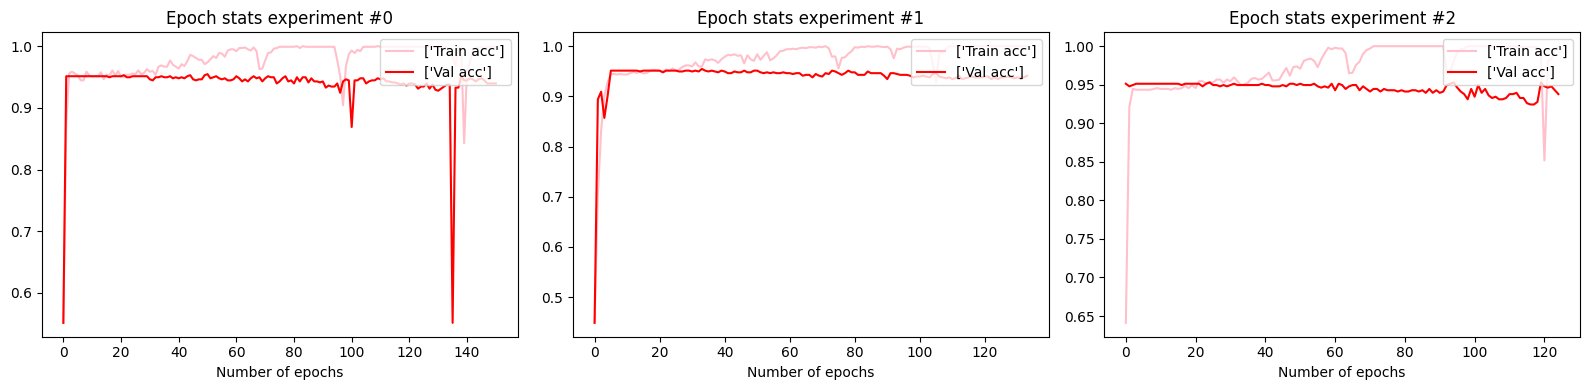

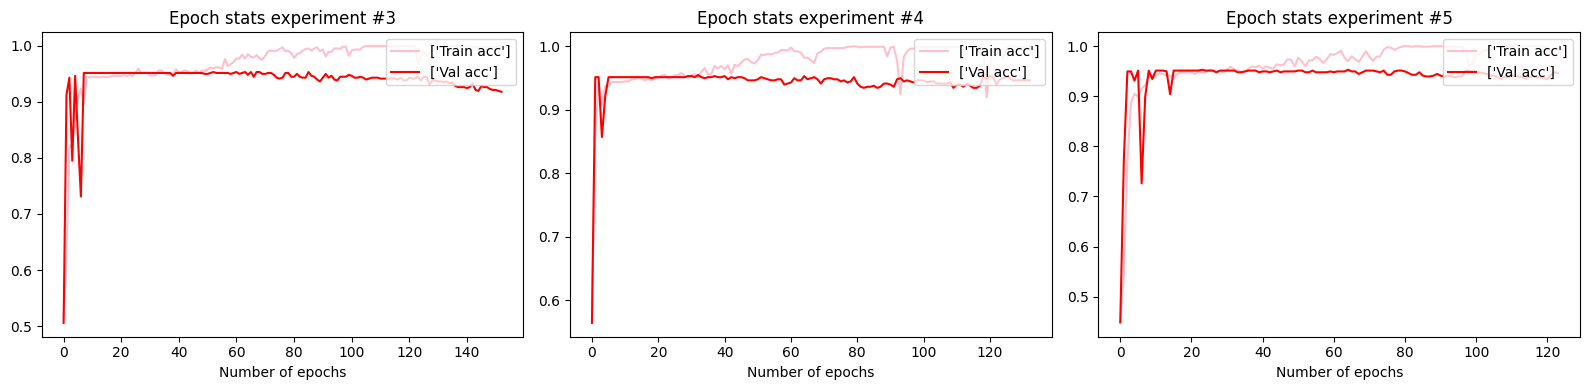

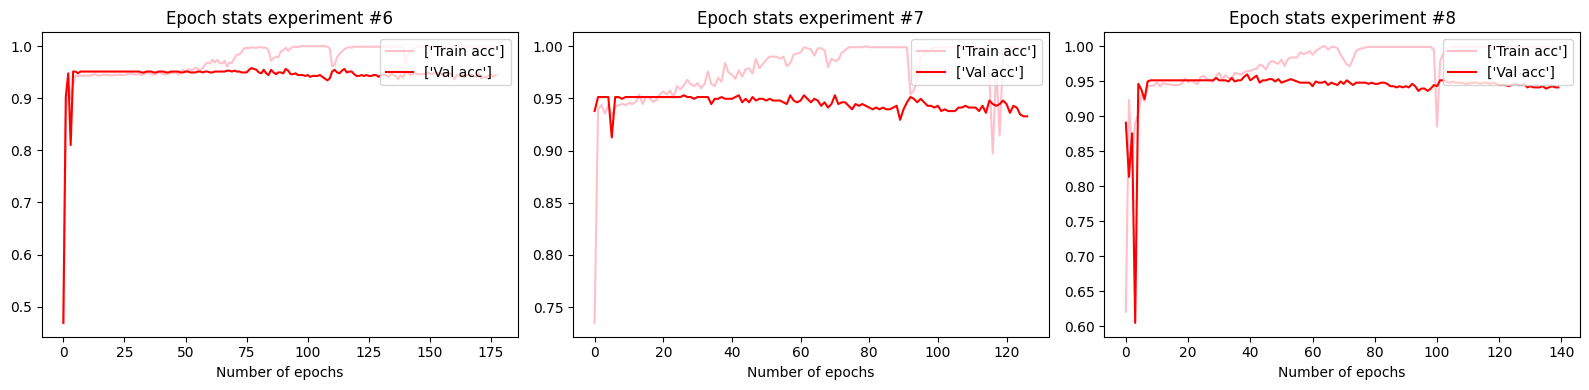

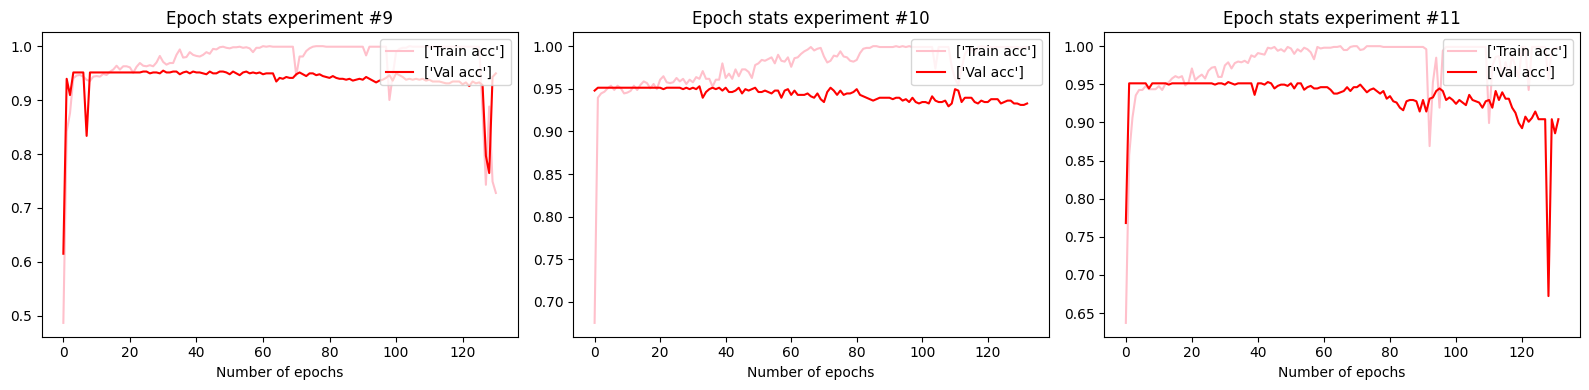

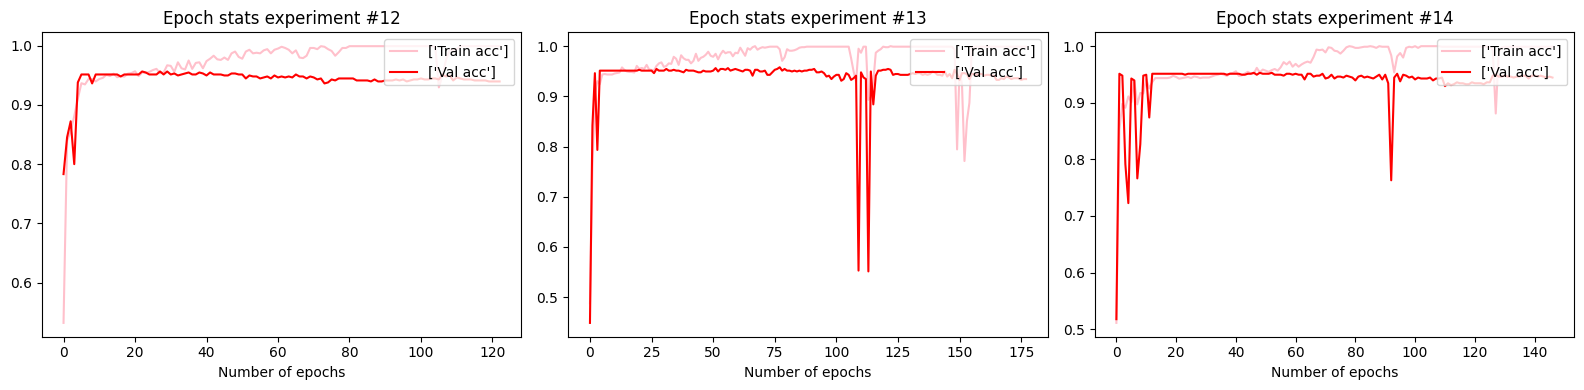

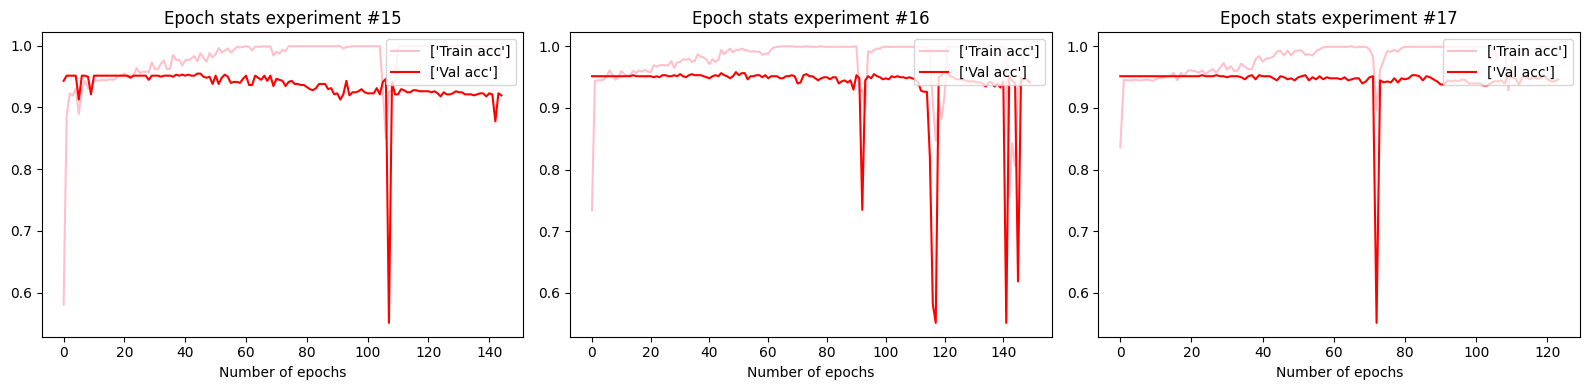

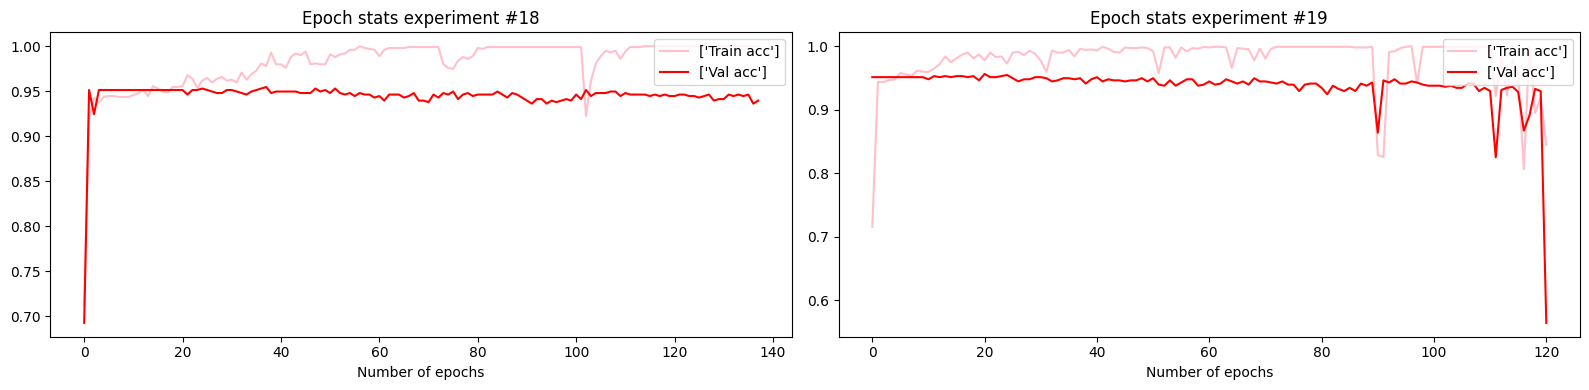

In [43]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

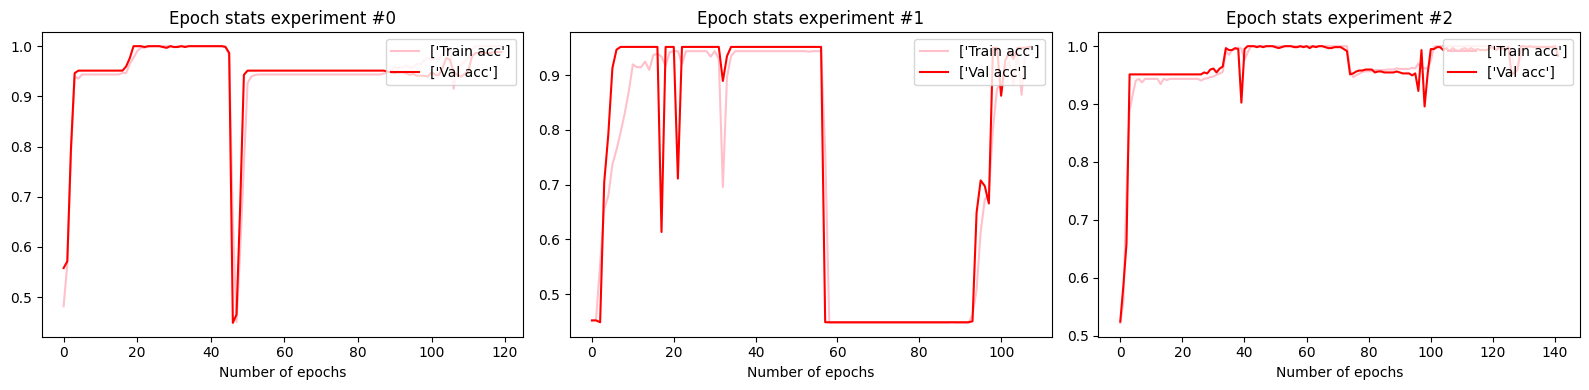

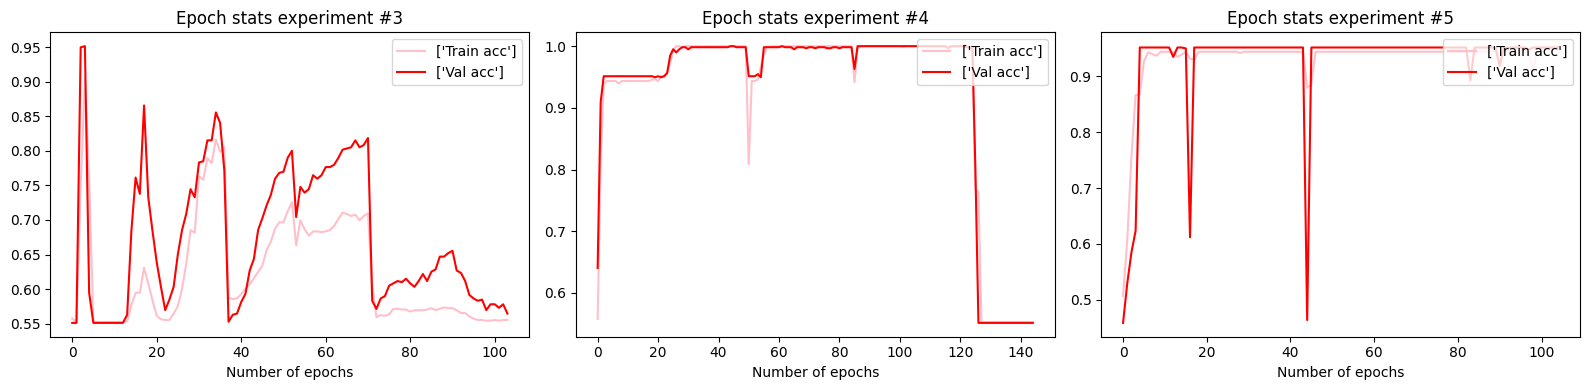

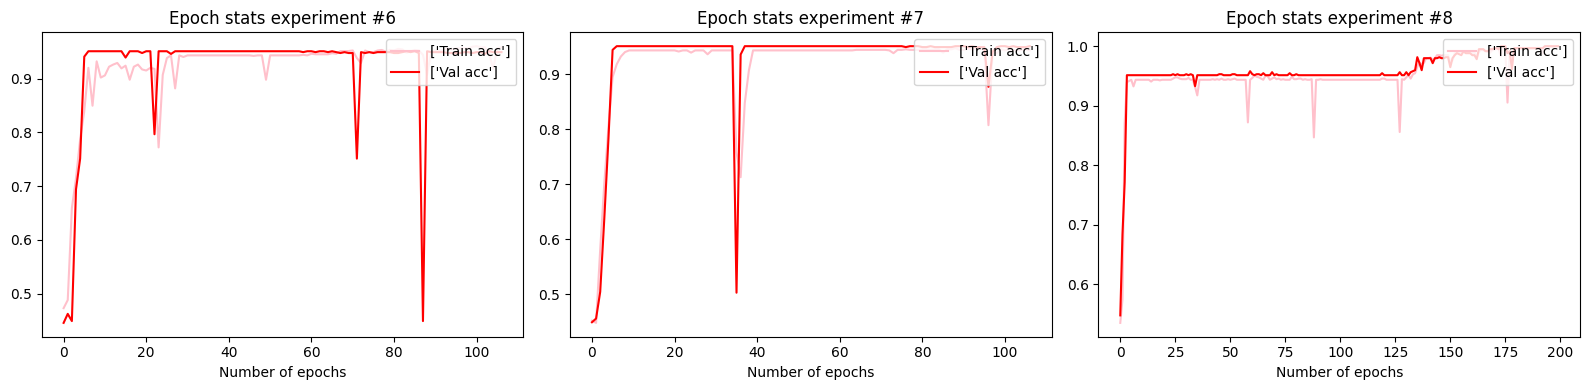

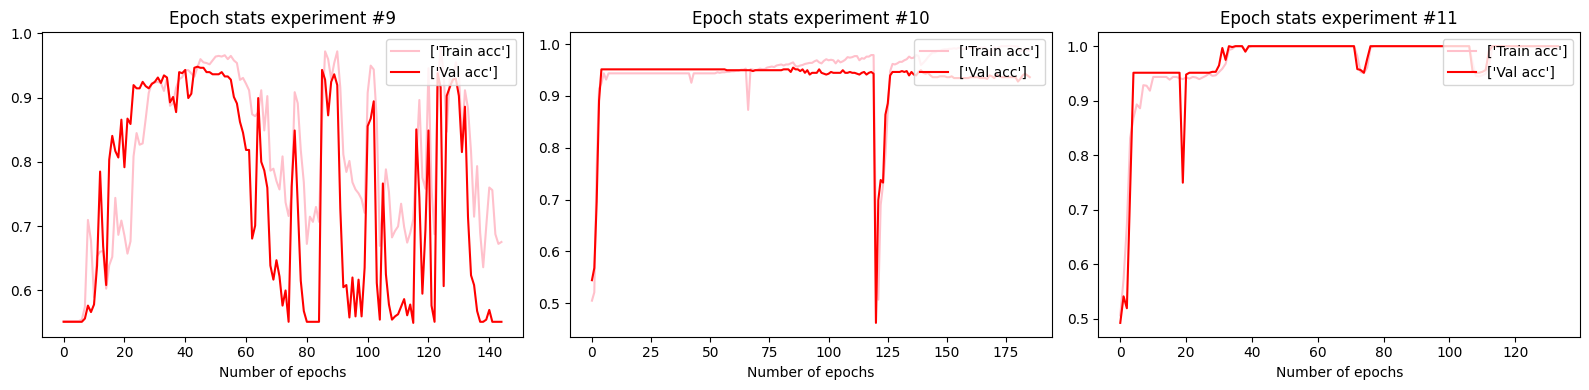

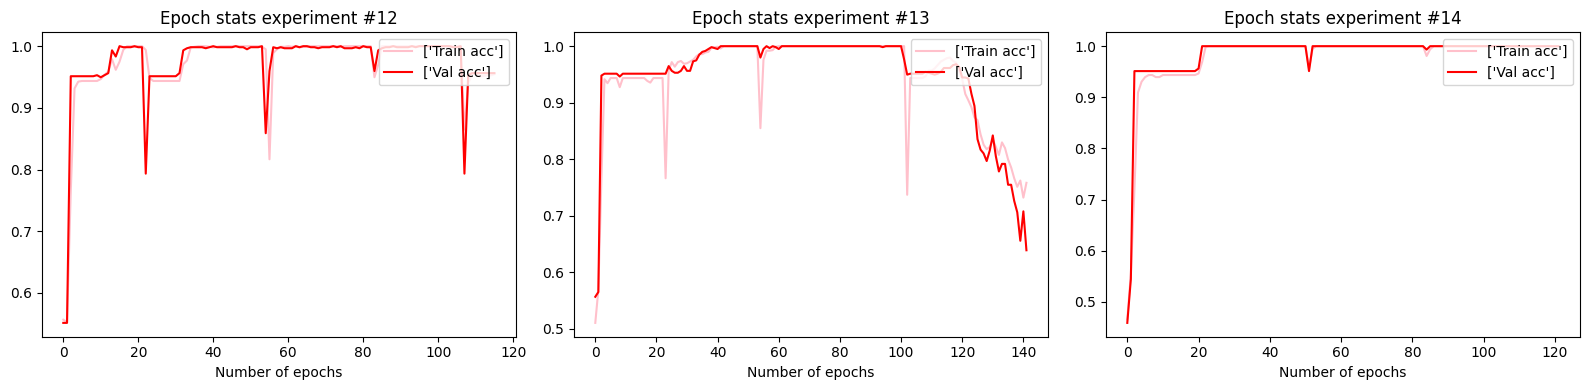

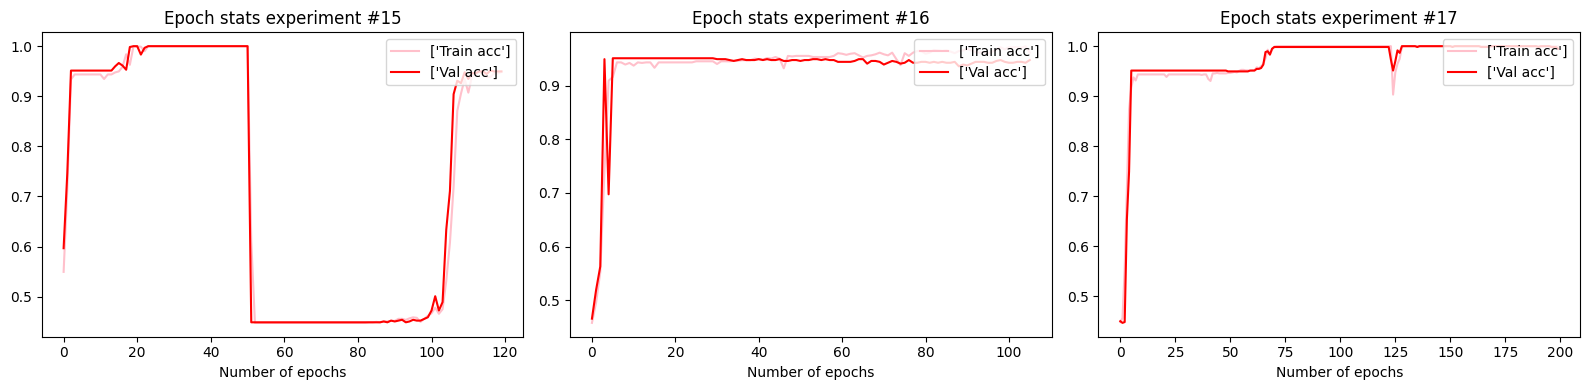

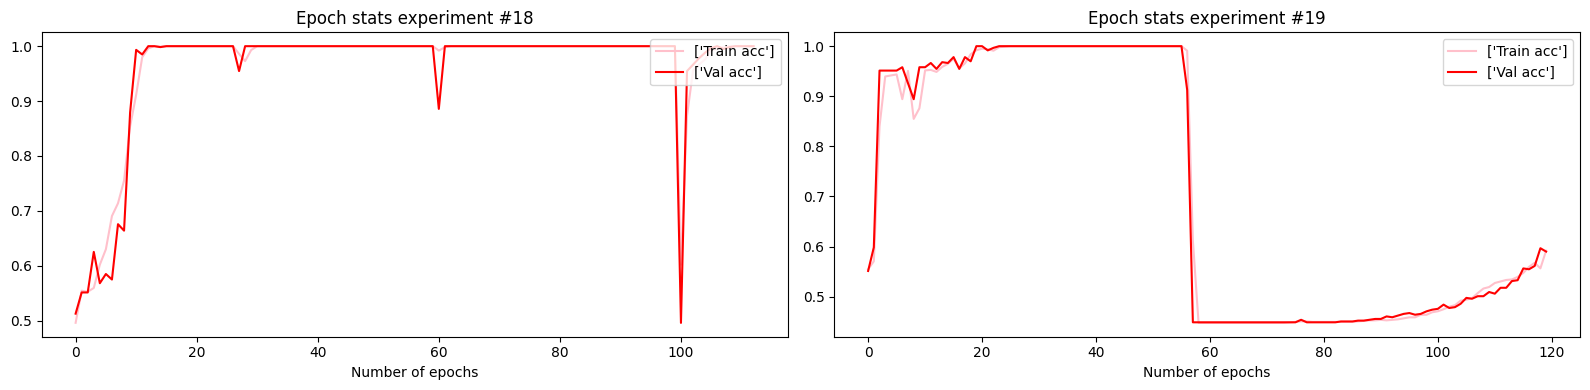

In [44]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

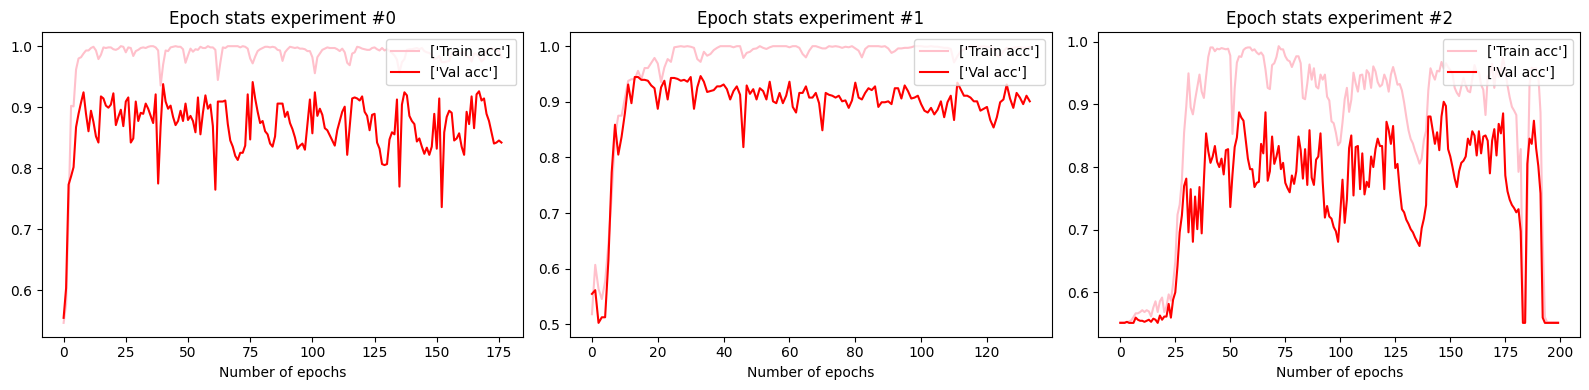

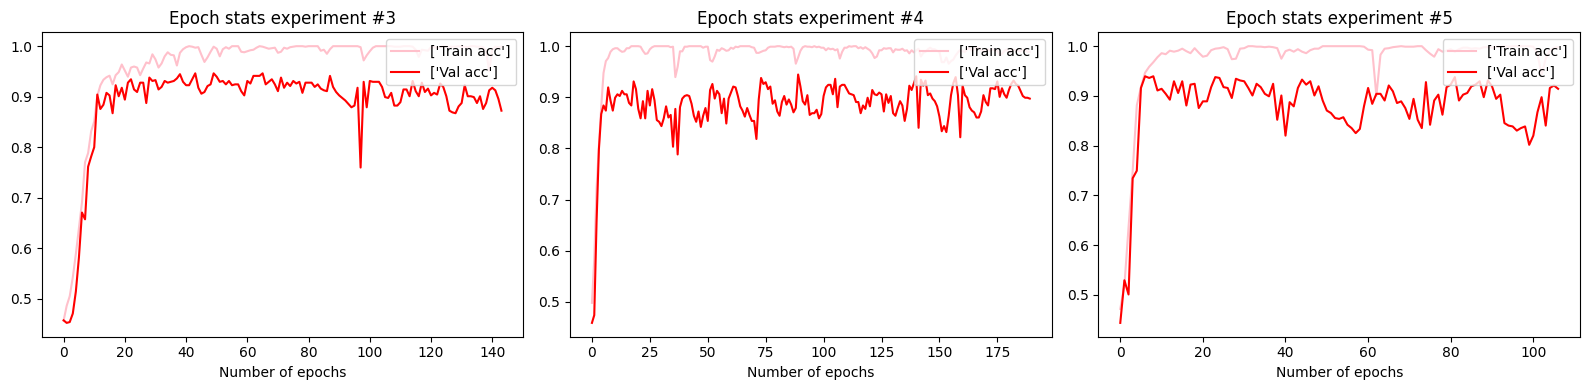

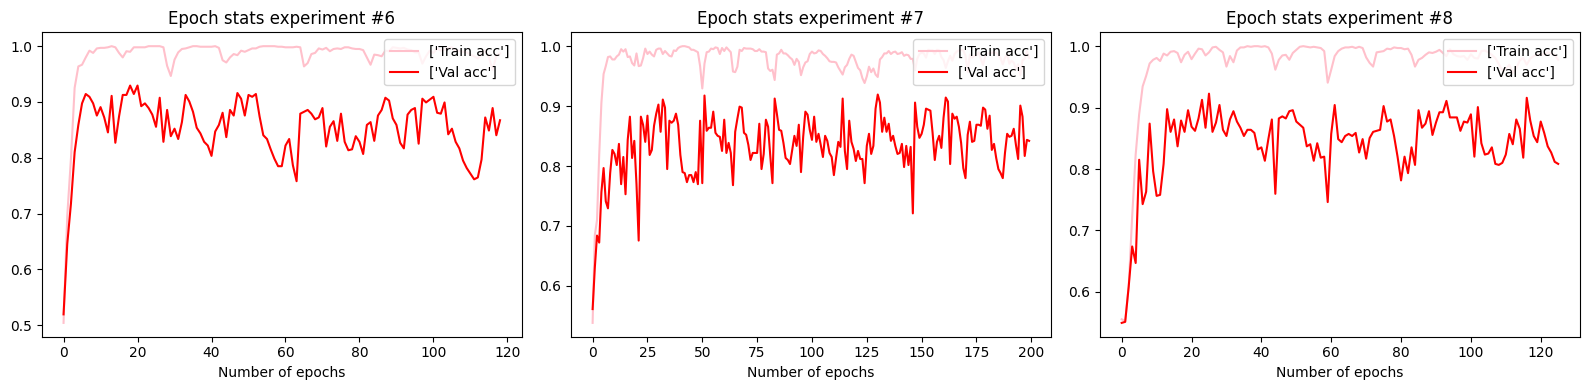

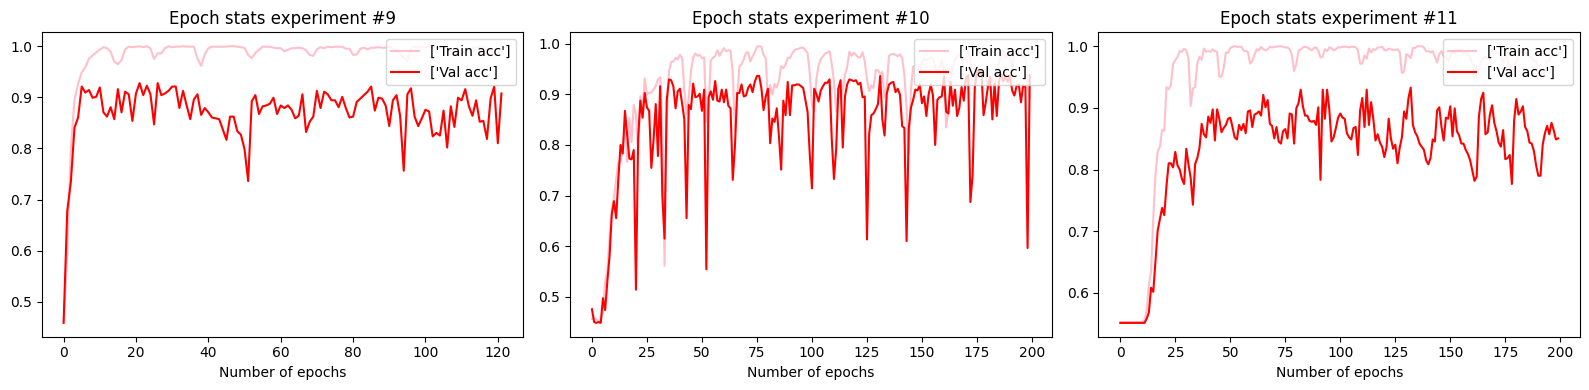

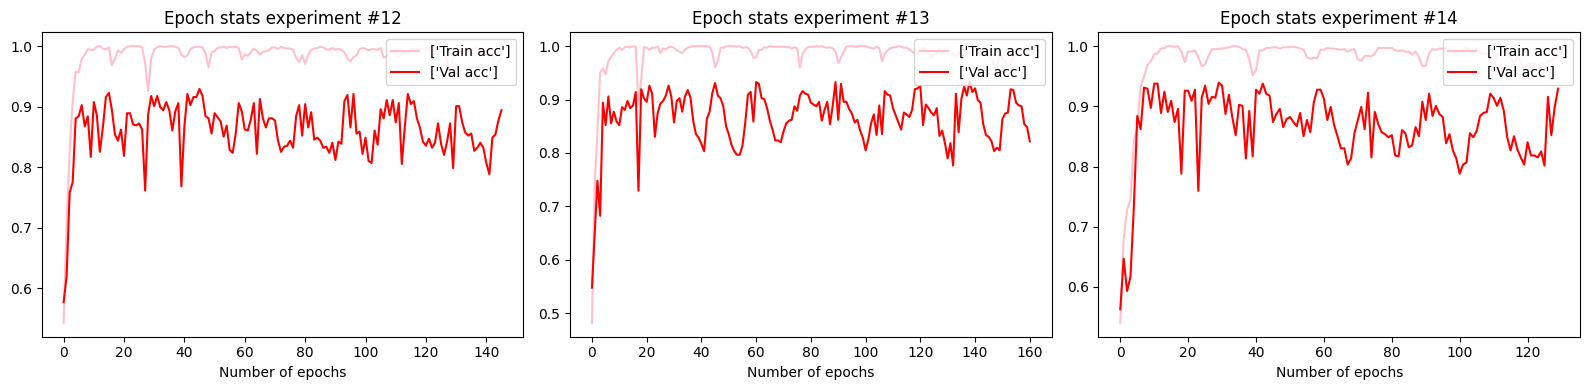

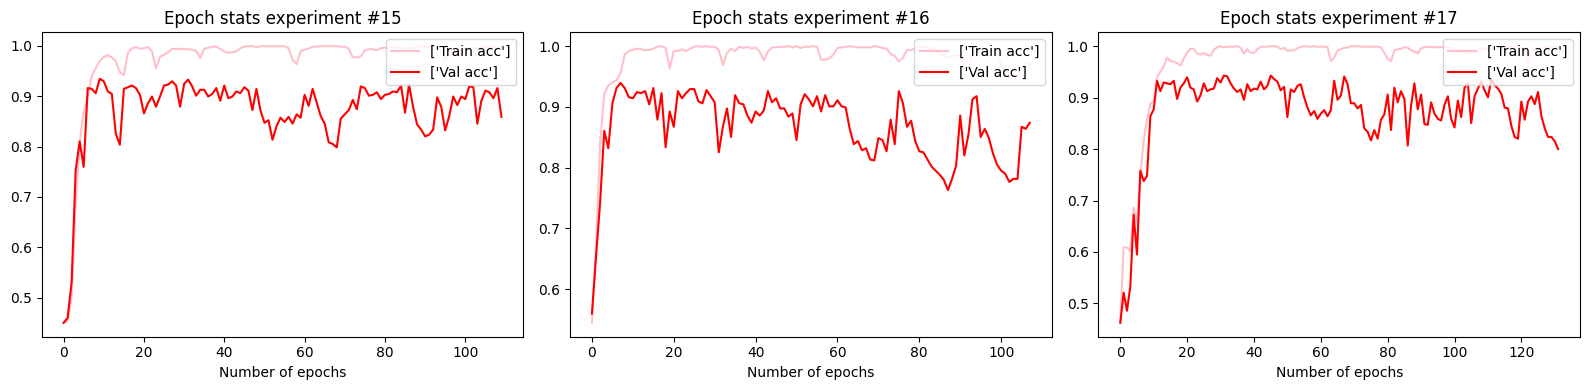

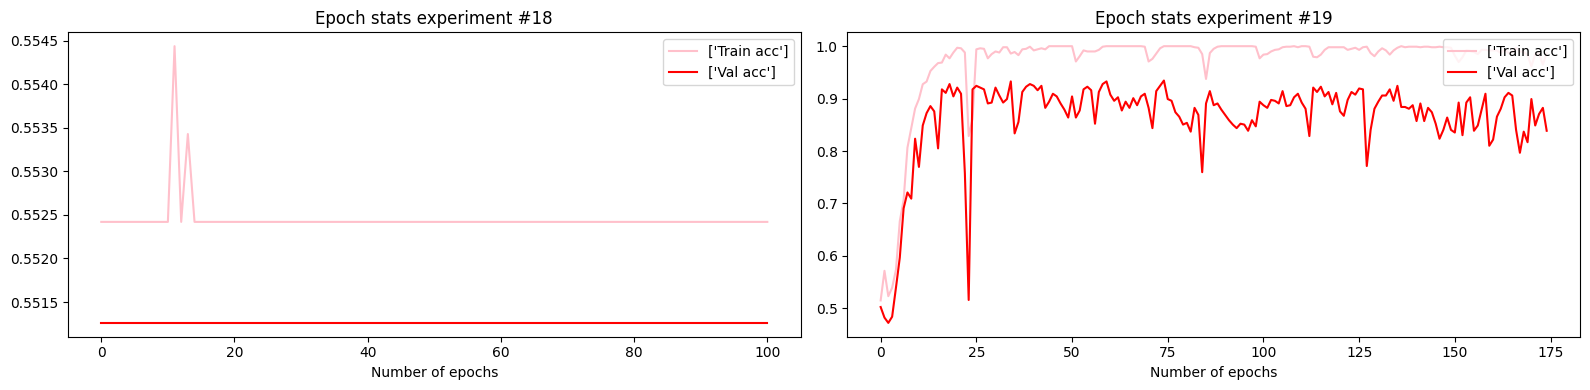

In [45]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

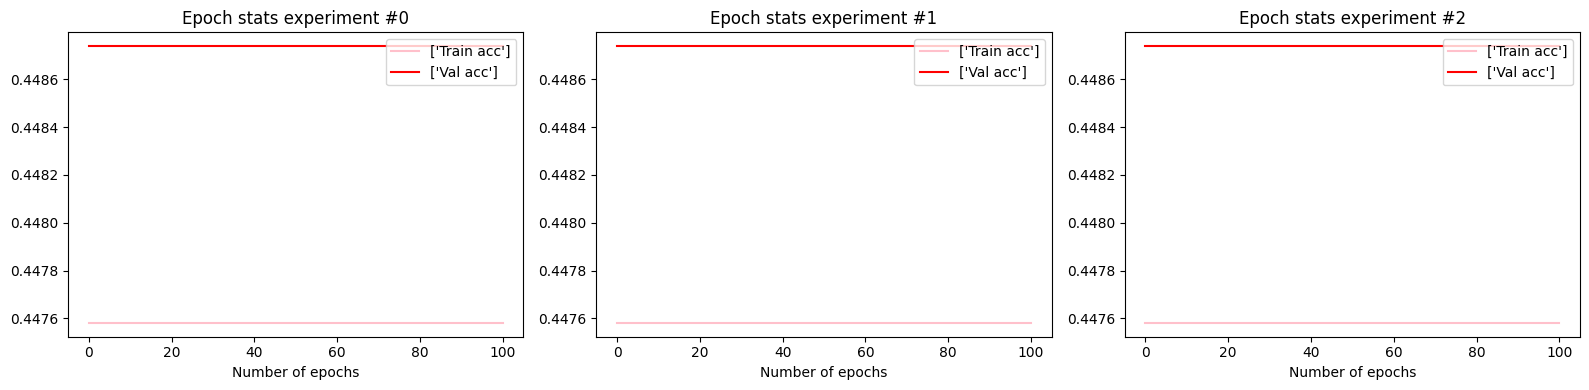

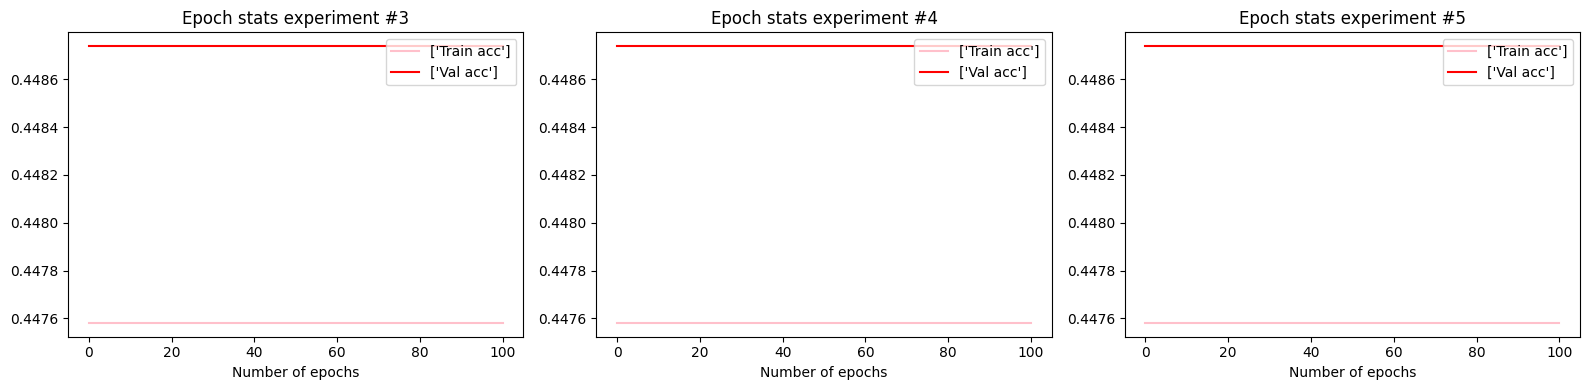

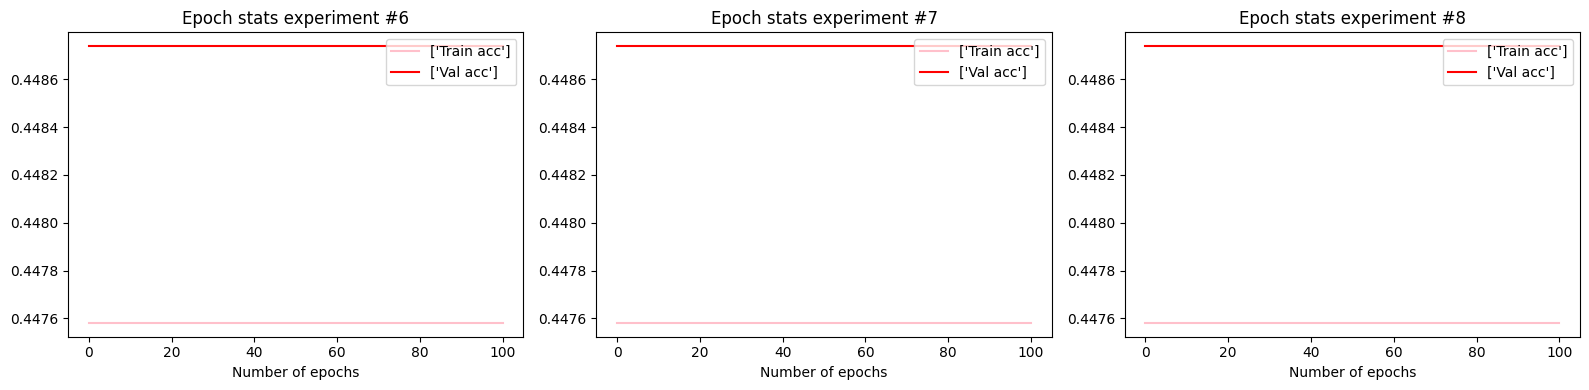

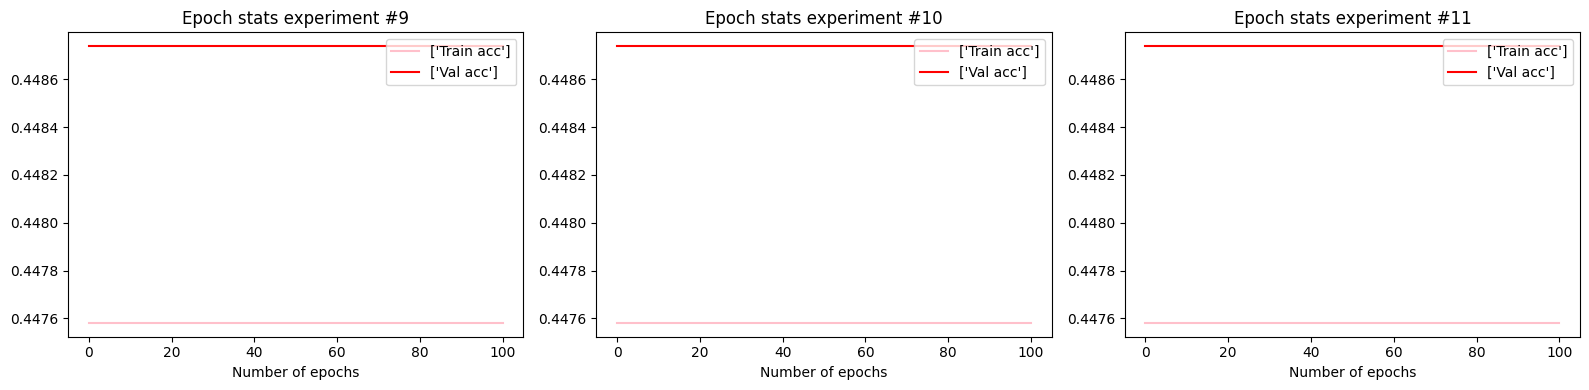

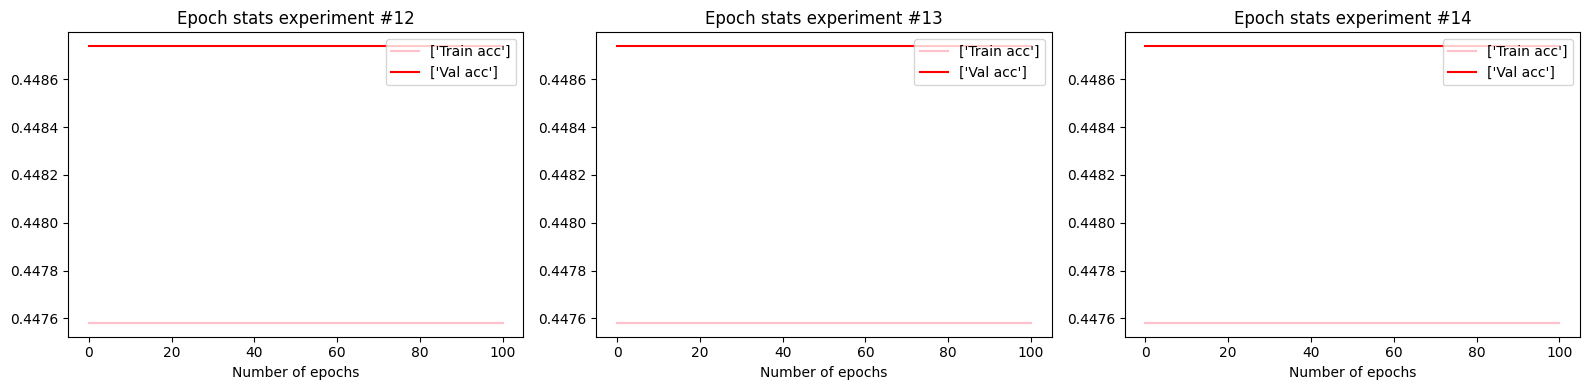

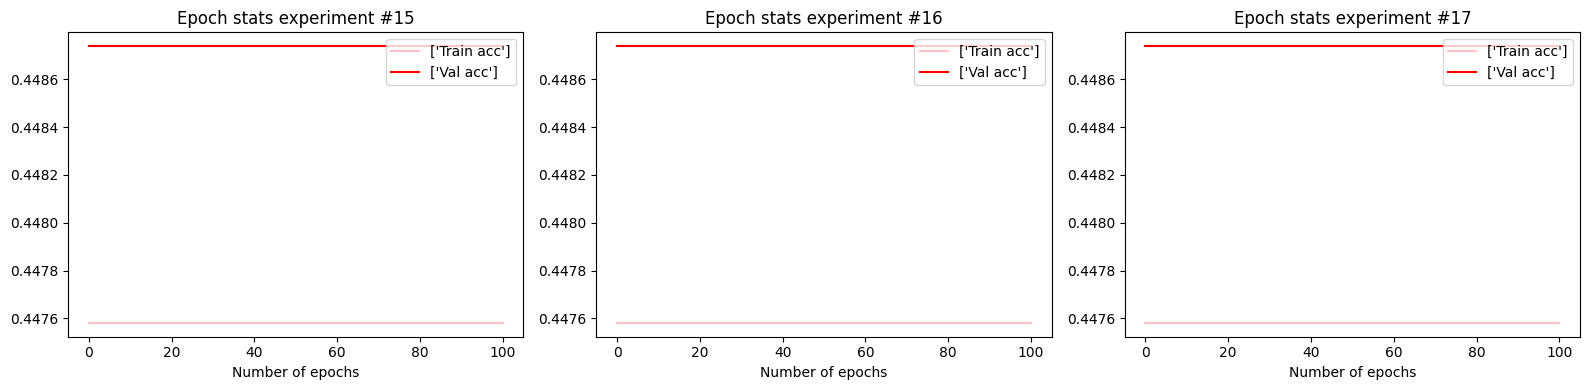

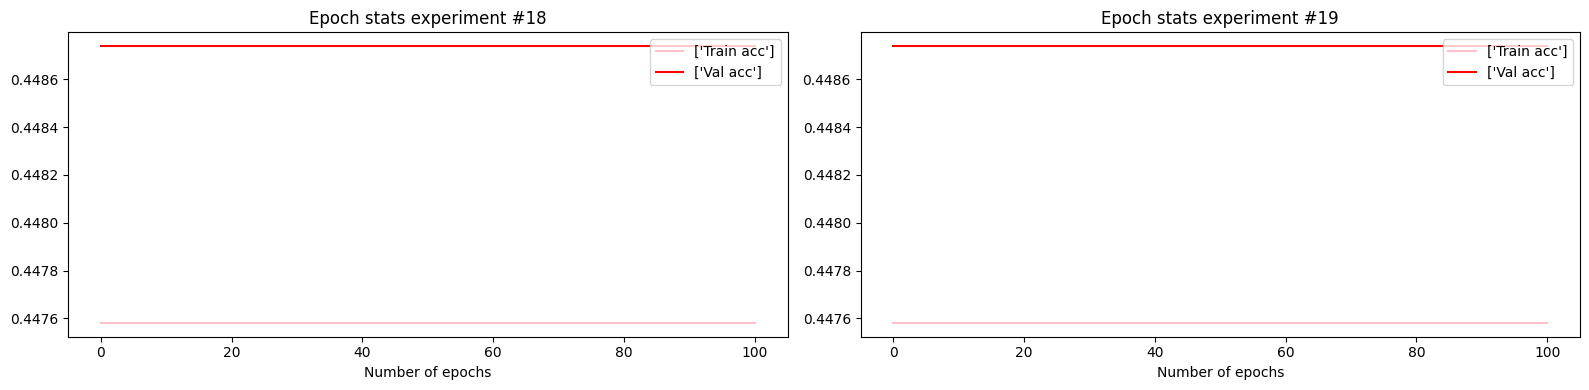

In [46]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

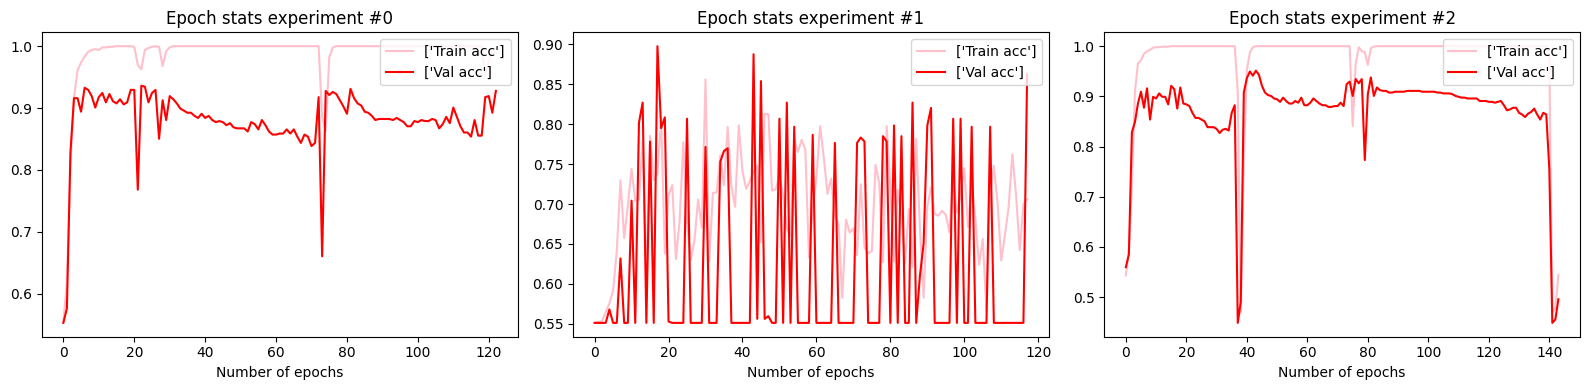

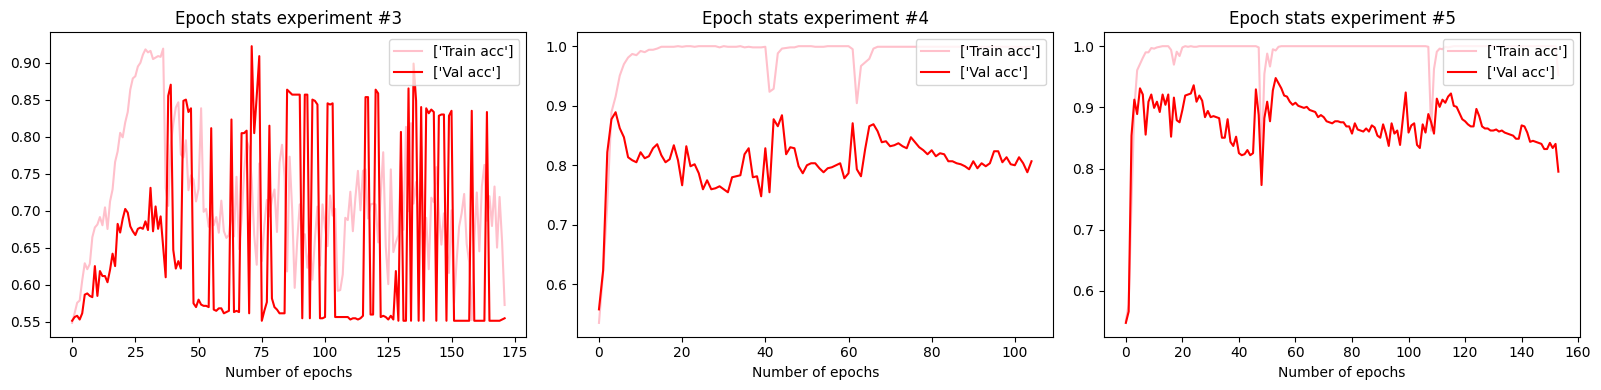

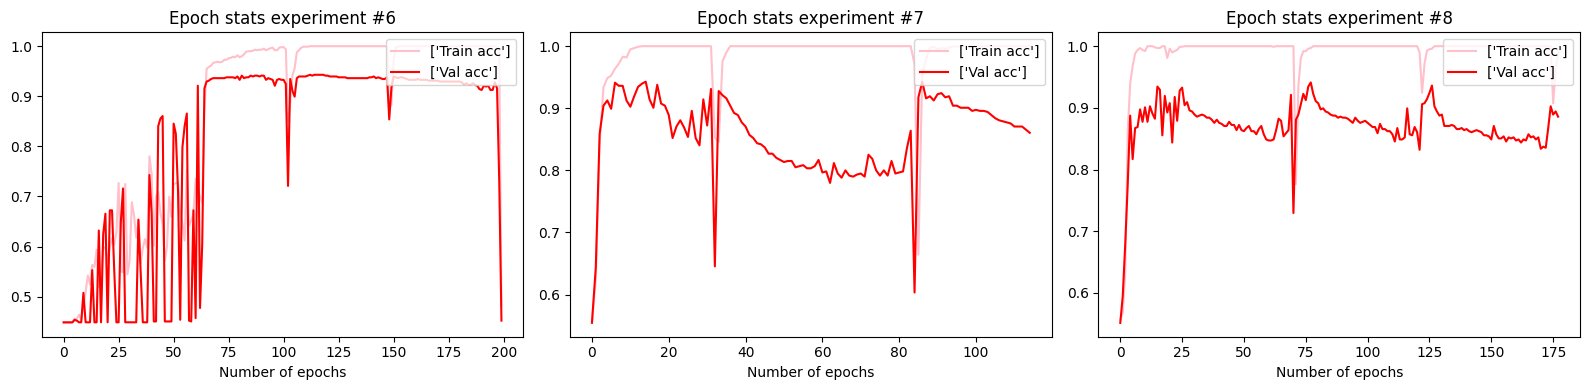

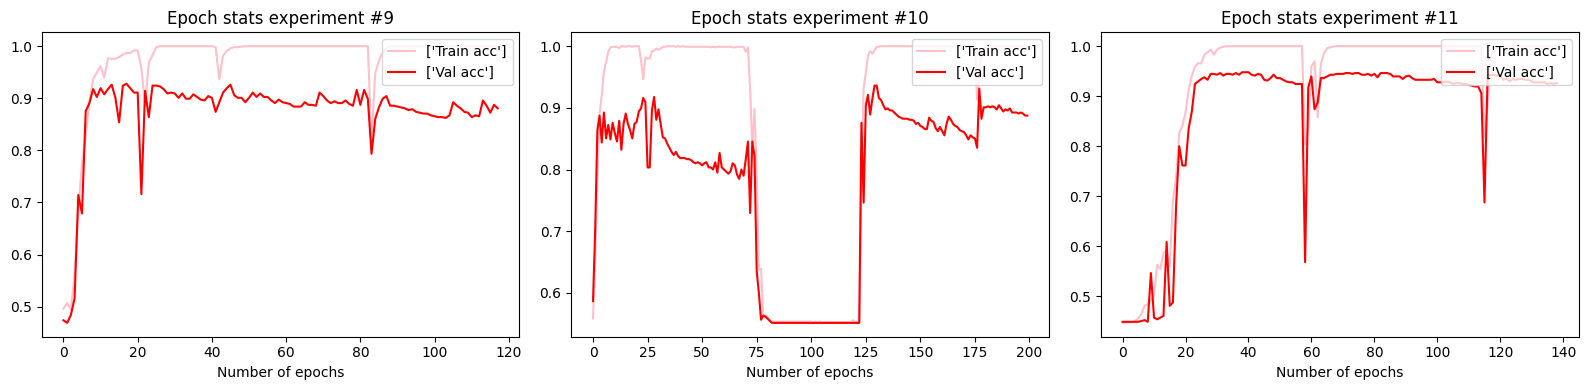

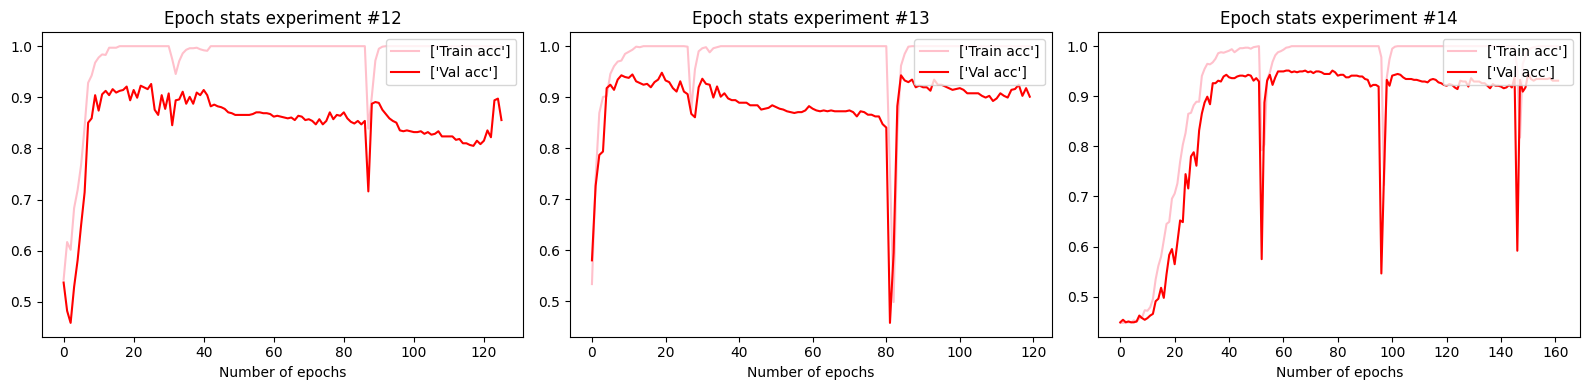

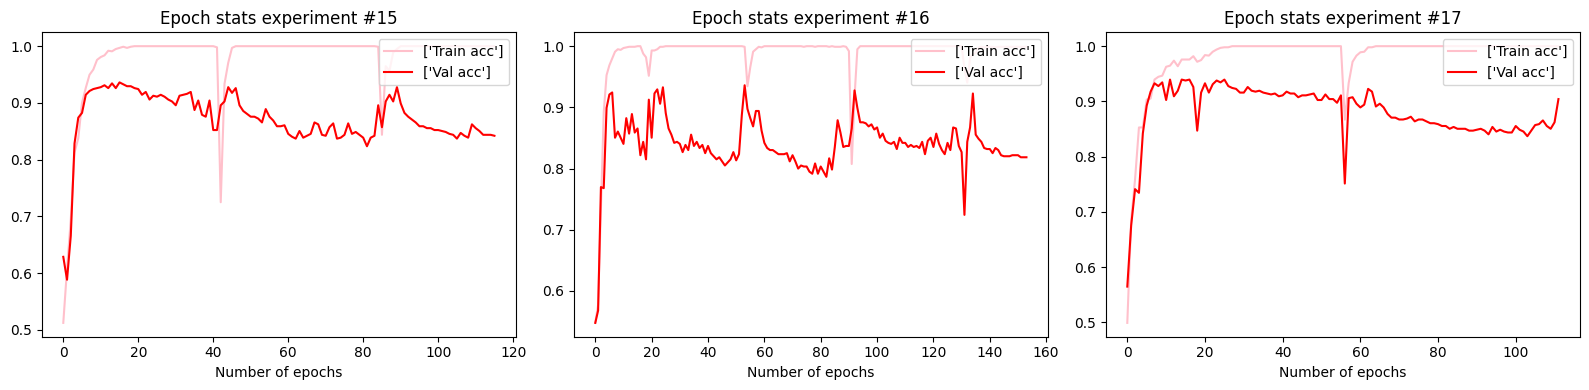

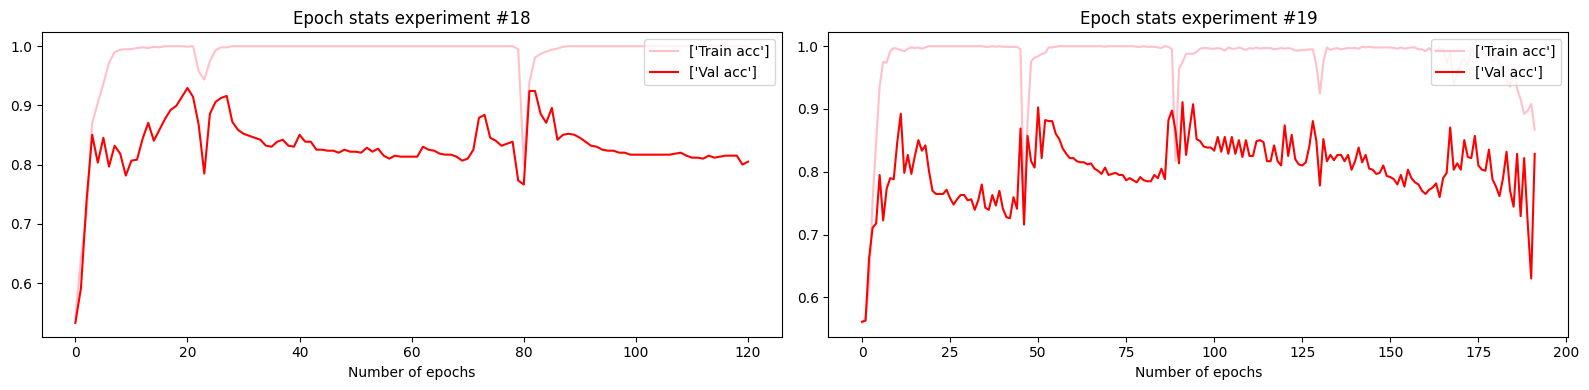

In [47]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [54]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('best_DEEPSET_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('best_FEEDFORWARD_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data, 16, 8).to(device)
best_deepsetv2_model.load_state_dict(torch.load('best_DEEPSETV2_model_' + experiment_name))


C:\Users\franm\AppData\Local\Temp\ipykernel_21016\892596777.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_lstm_model.load_state_dict(torch.load('best_LSTM_model_'

RuntimeError: Error(s) in loading state_dict for DEEPSETV2_Model:
	size mismatch for densef1_2.weight: copying a param with shape torch.Size([32, 1]) from checkpoint, the shape in current model is torch.Size([16, 1]).
	size mismatch for densef1_2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef2_2.weight: copying a param with shape torch.Size([32, 1]) from checkpoint, the shape in current model is torch.Size([16, 1]).
	size mismatch for densef2_2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef3_2.weight: copying a param with shape torch.Size([32, 1]) from checkpoint, the shape in current model is torch.Size([16, 1]).
	size mismatch for densef3_2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef1_3.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for densef2_3.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for densef3_3.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).

## Top wrong predictions for best performing CNN model

In [55]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 

.___._,wu.,._._, .._,._..._,,.dr. | label: False | actual prediction: 0.9740792512893677
_,,__,...,wu..._ ,_,.,..,_,__..dr | label: False | actual prediction: 0.9689406156539917
,wu.__,,,,,.,.,_ _dr.,,.__,._,___ | label: False | actual prediction: 0.9679897427558899
,..__,_,wu,._.,_ ._,,,,,...,.dr,, | label: False | actual prediction: 0.9679642915725708
...,,.,_.,wu,_._ ,,dr....,__...,, | label: False | actual prediction: 0.9676486253738403
_,._,wu._,_,,_., .,..._dr.__...,_ | label: False | actual prediction: 0.967488169670105
_...,,_.,,_wu... ___dr_,.._...._. | label: False | actual prediction: 0.96741783618927
_,wu_...,____.,_ _,,dr,,.,,__..__ | label: False | actual prediction: 0.9624750018119812
.._,__.,wu_._.__ .,_,,.,_.__dr.,, | label: False | actual prediction: 0.9614902138710022
_,.,_,wu,..._.,, dr__.._,._._.,,_ | label: False | actual prediction: 0.9612160921096802

Top 10 false negatives: 

_...__,__._.wu__ r__,_,__._,,..,, | label: True | actual pre

## Top wrong predictions for best performing LSTM model

In [56]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

,,,_,.__,,...wu_ .,._.,,,,_r_,,,. | label: True | actual prediction: 0.5038686990737915
_._.,._,.._.,.wu ......_,_._,,r,_ | label: True | actual prediction: 0.5486049652099609
,.,,..,,_.,,.wu. .___._.,,,.,,_.r | label: True | actual prediction: 0.549419105052948
,__.__,,.,..,_., ,dr,,,.,.,,.,... | label: True | actual prediction: 0.5790737867355347
_.__._,_,_.,,wu. ,_,.r,,...,,_,,, | label: True | actual prediction: 0.5807053446769714
,_,.,,_,_.,_,wu_ ,,._,._,_r,,,,._ | label: True | actual prediction: 0.5872901082038879
..._,,_,..__.wu. r_,,.,,....._,,, | label: True | actual prediction: 0.6039365530014038
,wu...._..,_,_,. .,.,r,.,.._,_.__ | label: True | actual prediction: 0.6051635146141052
.,..,.____,_,.wu .,_r,,.,,_,,.___ | label: True | actual prediction: 0.6058986186981201
.,,,....,._.,wu_ .r_.,,,,_,,._,__ | label: True | actual prediction: 0.6063191294670105




## Top wrong predictions for best performing DeepSets V1 model

In [57]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

,..,_.wu...._,,, ,.,,,,,dr._,.__, | label: False | actual prediction: 0.9950018525123596
_wu,_,_,_.,,,.._ _.,._,_,,.dr.,,. | label: False | actual prediction: 0.9950002431869507
,,.,wu,.,,,._,,. _.,.dr,,,._...,. | label: False | actual prediction: 0.994939923286438
._,,_.___,,wu_,, _dr,,_,_..,_.,.. | label: False | actual prediction: 0.9949089884757996
.,_.,_,wu__,.___ dr_,.__,_,._,,_. | label: False | actual prediction: 0.9949073195457458
,...,,,..wu.,_,. ,.._dr_,_,__..__ | label: False | actual prediction: 0.9948540329933167
,,...,,._wu.,... ,_._.,._,.dr.,_, | label: False | actual prediction: 0.994850218296051
,__,,..,.wu,__,. ___._.dr_,_,,._. | label: False | actual prediction: 0.9948405623435974
,._..wu,___.___. ,.,_,_.,.._dr.__ | label: False | actual prediction: 0.994835376739502
_.,_,.__wu_,_.,. __,.,_dr,,__._,. | label: False | actual prediction: 0.9948216676712036

Top 10 false negatives: 

,,__,,,___,.,___ dr_,_,.,.,.._,,_ | label: True | actual pre

## Top wrong predictions for best performing DeepSets V2 model

In [58]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

,.,......,.,_.,. ,,,..._,_dr,_,,, | label: True | actual prediction: 0.5
_._.w..,..__,... _____,..,.,...dr | label: True | actual prediction: 0.5
,_,.,,_,_.,_,wu_ ,,._,._,_r,,,,._ | label: True | actual prediction: 0.5
_,._uw____,_,__. _._...,_,_,r._._ | label: True | actual prediction: 0.5
,_._.,,uw_,_,,,_ .r,_..__,..,,._. | label: True | actual prediction: 0.5
,._._,uw___..,__ __...,.__.r_._.. | label: True | actual prediction: 0.5
,_.,uw.,__,,..., ,..,.,_..__..,.r | label: True | actual prediction: 0.5
.,wu._,_____..._ .,r.___,..._,,.. | label: True | actual prediction: 0.5
,uw.._,,._.__,_. ___._.__,__dr.,. | label: True | actual prediction: 0.5
.,__,._.._.._._w .__,,.,_,,r,___. | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [59]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

_,wu_...,____.,_ _,,dr,,.,,__..__ | label: False | actual prediction: 0.7596895694732666
_.__wu._,,....,. _,..__,..dr...._ | label: False | actual prediction: 0.7477260828018188
._wu.,,.,____._, ..,.._dr.,_.._.. | label: False | actual prediction: 0.747454047203064
_...,,_.,,_wu... ___dr_,.._...._. | label: False | actual prediction: 0.74007648229599
,.wu.,,.__.._,,. ___,_..__..,,.dr | label: False | actual prediction: 0.7394925355911255
_._wu,,.._._,,_, ,,,_,._dr,._,._, | label: False | actual prediction: 0.7379440665245056
_.,_,.__wu_,_.,. __,.,_dr,,__._,. | label: False | actual prediction: 0.7348867654800415
,_wu_,__,,____,_ _.__,dr.,,,_,_., | label: False | actual prediction: 0.7344498634338379
_,,,,._,,._wu___ ._,,.,,_,,dr___. | label: False | actual prediction: 0.732817530632019
,wu.__,,,,,.,.,_ _dr.,,.__,._,___ | label: False | actual prediction: 0.7317232489585876

Top 10 false negatives: 

,_.,__,,.w_,__.. .,.___.,.,,.,dr. | label: True | actual pred

# Saving Notebook State

In [60]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

ModuleNotFoundError: No module named 'dill'

# Loading Notebook State

In [ ]:
import dill
experiment_name = "25per"
# dill.load_session('notebook_env_' + experiment_name + '.db')